**Q 9.6**

**Part a)**

Here, we are to set the seed value, and split the data into train and test using the outlined sizes. While I would do this at the beginning as outlined in the question, it doesn't make sense given the data processing required. So, I will very clearly indicate when this is done further into the code. 

**Part b)** 

Preparing the non-numerical data for analysis, we begin by reading the appropriate packages:

In [5]:
library(readxl)
library(tidyverse)
library(caret)
library(fastDummies)
library(dplyr)
library(tree)
library(rpart)

In [6]:
# read in the data
t = read_xls("default of credit card clients.xls")
# save the names of the cols in a separate list
row_names = t[1,]
# get rid of the first row & column 
t = t[-c(1), -c(1)]
# convert the character columns to numeric as required
t [, 5:23] = t[, 5:23] %>% mutate_if(is.character, as.numeric)

New names:
* `` -> `...1`


Now, we consider actually modifying the data. The process is outlined in the comments of the below code. 

In [7]:
# change the 0s to 1s and 1s to 2s
t$Y = ifelse(t$Y == 0, 1, 2)
# prep the one hot encoding with strings, first
# X2: Gender (1 = male; 2 = female).
t$X2 = ifelse(t$X2 == 1, "male", "female")
# X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
t$X3 = ifelse(t$X3 == 1, "graduate school",
              ifelse(t$X3 == 2, "university", 
              ifelse(t$X3 == 3, "high school", "other")))
# X4: Marital status (1 = married; 2 = single; 3 = others).
t$X4 = ifelse(t$X4 == 1, "married",
              ifelse(t$X4 == 2, "single", "other"))
# convert Y into factor
t$Y = as.factor(t$Y)

Now, I used the fastDummies package to create dummy variables representing the non-ordinal categorical variables. 

In [8]:
# save a copy of the dataframe
df = t
# one-hot encoding
df = dummy_cols(df, select_columns = c("X2", "X3", "X4"), 
                remove_first_dummy = TRUE)
# reorder the columns of the dataframe
reord_df = df[, c(1,25:ncol(df), 2:24)]
# get rid of the X2, X3, and X4 variate columns
reord_df = reord_df[,-c(8, 9, 10)]
colnames(reord_df) = make.names(colnames(reord_df))

**Actually doing part a)**

Now, I set the seed, and create a train and test split, using the sample() function. 

In [9]:
# set the seed first
set.seed(3675309)
# first sample 1000 obs from the dataframe
all_1000 = sample(1:nrow(reord_df), size = 1000)
# then get 700 indices for the training data
train_idx = sample(all_1000, size = 700)
# finally, 300 remaining indices for the test data
test_idx = setdiff(all_1000, train_idx)

# retrieve the training and test data from the dataframe
train_data = reord_df[train_idx,]
test_data = reord_df[test_idx, ]

**Part c)**

Here, we actually build the classification tree. I begin by creating a simple function to compute the error rate - being equal to 1 subtract the accurate classification rate. 

In [10]:
calc_error_rate = function(actual, predicted) {
  1 - mean(actual == predicted)
}

Now, we simply use the tree() function via the tree package to create a classification tree. 

[1] 0.2133333

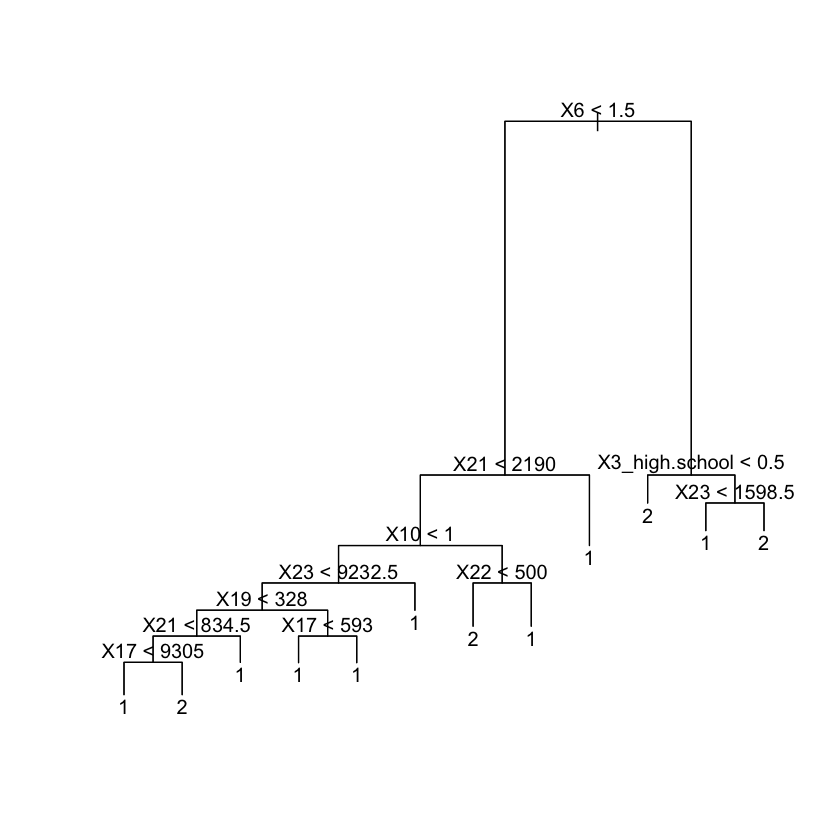

In [11]:
basic_tree = tree(Y~., data = train_data)
# plotting
plot(basic_tree)
text(basic_tree, pretty = 0)
# make predictions
preds_basic = predict(basic_tree, newdata = test_data, type = "class")
# calculate the error rate
calc_error_rate(actual = test_data$Y, predicted = preds_basic)

So, we have an error rate of roughly 21.3% in our base tree. 

**Part d)**

Here, we now prune the tree. I will be using the cv.tree() method to determine our desired size/k-value. 

In [12]:
cross_val = cv.tree(basic_tree, FUN = prune.misclass, K = 10)
cross_val

$size
[1] 12 11  7  5  2  1

$dev
[1] 140 140 139 133 133 165

$k
[1]      -Inf  0.000000  1.250000  2.500000  2.666667 40.000000

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

As we can see, at a $k$-value of $k = 2.5$, and thus a size of 5 terminal nodes, we minimize our dev value - being the number of misclassified observations. So, we will prune our tree to a size of 5 (as it seems that plugging the $k$ value into the prune.tree() function doesn't explicitly co-operate). The default argument for the method (deviance) was used for the pruning. 

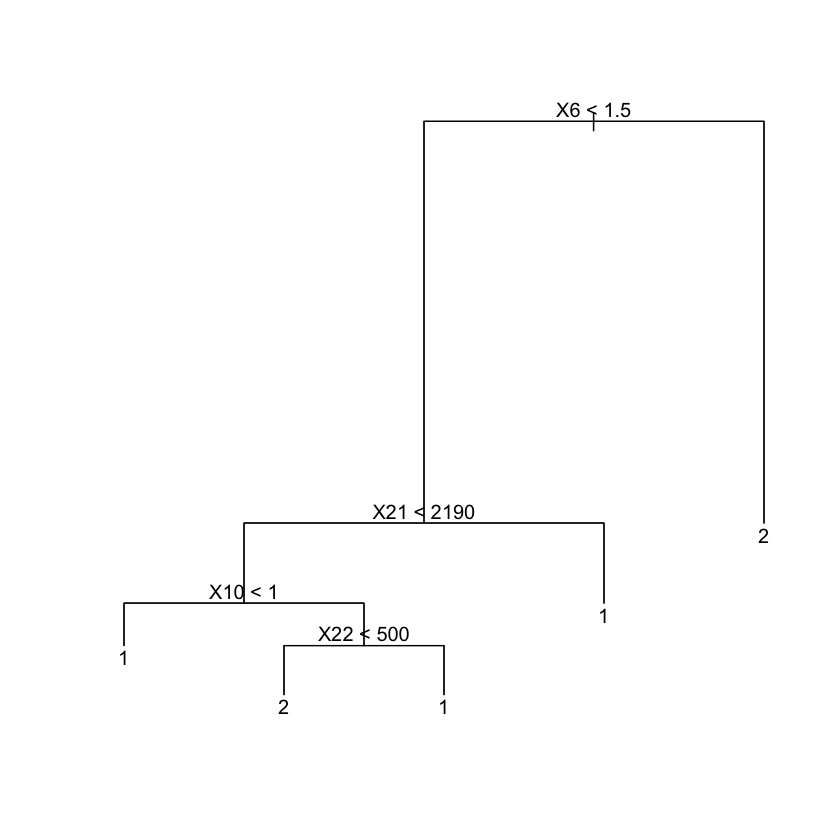

In [18]:
# getting the position of the best k-value
best_k_idx = which.min(cross_val$dev)
# getting the best k-value
best_k = cross_val$k[best_k_idx]
# getting the best size
best_size = cross_val$size[best_k_idx]
pruned_tree = prune.tree(tree = basic_tree, best = 5)
# Plot the pruned tree
plot(pruned_tree)
text(pruned_tree, pretty = 0)

Now, I predict and note the error rate. 

In [19]:
preds_prune = predict(pruned_tree, newdata = test_data, type = "class")
calc_error_rate(actual = test_data$Y, predicted = preds_prune)

[1] 0.22

As we can see, the error rate here is roughly 22% - so, our pruned tree does not reduce the error rate, making it ever-so-slightly higher. Also of note is that we had the alternative option of $k = 2.666667$, corresponding to a size of 3. This leads to a test error rate of 23%, also worse. 

**Part e)** 

Allow me to convince myself that trees are unstable. I will choose a different seed, and plot again. 

In [20]:
# set the seed first
set.seed(4110374)
# first sample 1000 obs from the dataframe
all_1000 = sample(1:nrow(reord_df), size = 1000)
# then get 700 indices for the training data
train_idx = sample(all_1000, size = 700)
# finally, 300 remaining indices for the test data
test_idx = setdiff(all_1000, train_idx)

# retrieve the training and test data from the dataframe
train_data = reord_df[train_idx,]
test_data = reord_df[test_idx, ]

[1] 0.2133333

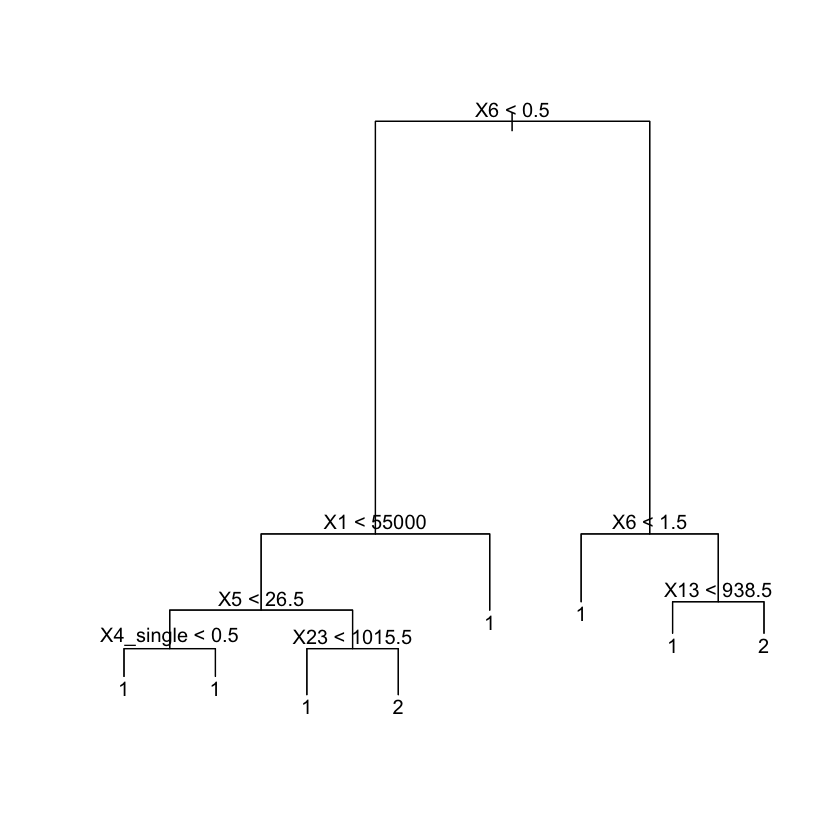

In [21]:
basic_tree2 = tree(Y~., data = train_data)
# plotting
plot(basic_tree2)
text(basic_tree2, pretty = 0)
# make predictions
preds_basic2 = predict(basic_tree2, newdata = test_data, type = "class")
# calculate the error rate
calc_error_rate(actual = test_data$Y, predicted = preds_basic2)

Do we get the same error rate? Yes. Do we also get a **completely** different tree? Also yes. The structure is far less convoluted, and a lot easier to follow compared to the previous original tree. 

So, you've sold me - these things are unstable. 